# Object Ranking

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from csrank import FATEObjectRanker

Using TensorFlow backend.


## The Medoid Ranking Problem

In the medoid problem the goal of the learner is to sort a set of randomly generated points based on their distance to the _medoid_.
This problem is inspired by the setting of ranking similarity learning, where the goal is to learn a similarity function from triplets of objects.

We will generate a random dataset where each instance contains 5 objects and 2 features for easy plotting.

In [2]:
from csrank import ObjectRankingDatasetGenerator
seed = 123
n_train = 10000
n_test = 10000
n_features = 2
n_objects = 5
gen = ObjectRankingDatasetGenerator(dataset_type='medoid', random_state=seed,
                                n_train_instances=n_train,
                                n_test_instances=n_test,
                                n_objects=n_objects,
                                n_features=n_features)

In [3]:
X_train, Y_train, X_test, Y_test = gen.get_single_train_test_split()

Let us plot a random instance. The points are ranked by distance to the medoid. The medoid itself gets always gets the index 0.

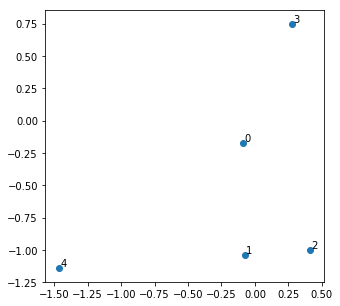

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
inst = np.random.choice(n_train)
ax.scatter(X_train[inst][:, 0], X_train[inst][:, 1])
for i in range(n_objects):
    ax.text(X_train[inst, i, 0]+0.01,
            X_train[inst, i, 1]+0.01,
            s=int(Y_train[inst, i]))

## The FATE network
The first-aggregate-then-evaluate approach learns an embedding of each object and then aggregates that into a _context_:
\begin{equation}
	\mu_{C(\vec{x})} = \frac{1}{|C(\vec{x})|} \sum_{\vec{y} \in C(\vec{x})} \phi(\vec{y})
\end{equation}
and then scores each object $\vec{x}$ using a generalized utility function $U (\vec{x}, \mu_{C(\vec{x})})$

In [5]:
from keras.optimizers import SGD
from csrank import FATEObjectRanker
from csrank.losses import smooth_rank_loss
fate = FATEObjectRanker(
    n_object_features=n_features,
    loss_function=smooth_rank_loss,
    optimizer=SGD(lr=1e-4, nesterov=True, momentum=0.9))

We will run the training for only 10 epochs to get an idea of the convergence:

In [6]:
fate.fit(X_train, Y_train, verbose=True, epochs=10)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 8s 848us/step - loss: 11.3143 - zero_one_rank_loss_for_scores_ties: 0.4318 - val_loss: 11.2180 - val_zero_one_rank_loss_for_scores_ties: 0.3547
Epoch 2/10
9000/9000 [==============================] - 1s 99us/step - loss: 11.2005 - zero_one_rank_loss_for_scores_ties: 0.3448 - val_loss: 11.1587 - val_zero_one_rank_loss_for_scores_ties: 0.3164
Epoch 3/10
9000/9000 [==============================] - 1s 112us/step - loss: 11.1526 - zero_one_rank_loss_for_scores_ties: 0.3150 - val_loss: 11.1150 - val_zero_one_rank_loss_for_scores_ties: 0.2932
Epoch 4/10
9000/9000 [==============================] - 1s 88us/step - loss: 11.1175 - zero_one_rank_loss_for_scores_ties: 0.2964 - val_loss: 11.0819 - val_zero_one_rank_loss_for_scores_ties: 0.2779
Epoch 5/10
9000/9000 [==============================] - 1s 160us/step - loss: 11.0899 - zero_one_rank_loss_for_scores_ties: 0.2850 - val_loss: 11.0541 - v

In [7]:
scores = fate.predict_scores(X_test)

In [8]:
from csrank.metrics import zero_one_rank_loss_for_scores
from keras import backend as K
K.eval(zero_one_rank_loss_for_scores(Y_test, scores))

0.26382047

Not converged yet, but let us visualize the scores it assigns to test instances:

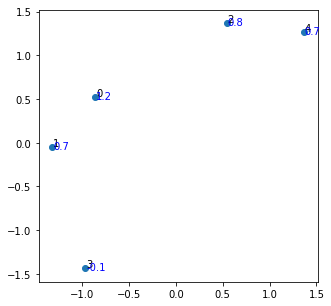

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
inst = np.random.choice(n_test)
ax.scatter(X_test[inst][:, 0], X_test[inst][:, 1])
for i in range(n_objects):
    ax.text(X_test[inst, i, 0]+0.01,
            X_test[inst, i, 1]+0.01,
            s=int(Y_test[inst, i]))
    ax.text(X_test[inst, i, 0]+0.01,
            X_test[inst, i, 1]-0.025,
            s='{:.1f}'.format(scores[inst][i]),
            color='b')